In [1]:
import os
import re

import shutil
import codecs, json 
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
from scipy import stats
import sklearn as sk
import time
from dypac import Dypac
import nilearn
from nilearn import image, plotting, datasets
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.decomposition import DictLearning, CanICA
from scipy.stats import pearsonr
import nilearn.plotting as plotting
import csv

import hcp_utils as hcp
import conf

import mne
from mne.datasets import sample
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.connectivity import spectral_connectivity
from mne.viz import circular_layout, plot_connectivity_circle
import plot_con_helper
import feature_selec_functions
import importlib

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


## Equalize number of parcels presented in the plot

In [81]:
#Paths to results 
PATH = conf.RESULTS_DIR

#Create a dict of all the dfs

dfs = ['df_DD_02', 'df_z_compare_f_scaledFeatures']
df_arranged = {}
for i in range(len(dfs)):
    path = PATH + '{}.csv'.format(dfs[i])
    df = pd.read_csv(path)
    df = df[['node1', 'node2', 'beta']]
    df_arranged[dfs[i]] = df

In [82]:
#For every df, checks if all pair of nodes that exist in both tasks exist in the df. 
#if not, append it to the df with a beta of np.nan.
importlib.reload(plot_con_helper)

df_arranged = plot_con_helper.equalize_parc(df_arranged)

In [83]:
df_arranged['df_z_compare_f_scaledFeatures']

,node1,node2,beta
0,LH_Vis_1,LH_DorsAttn_Post_5,0.031491
1,LH_Vis_1,LH_Limbic_TempPole_1,-0.035178
2,LH_Vis_1,LH_Default_Temp_2,-0.032224
3,LH_Vis_1,LH_Default_pCunPCC_2,0.031868
4,LH_Vis_1,RH_SalVentAttn_TempOccPar_1,0.068593
...,...,...,...
361,RH_Cont_Cing_1,RH_Default_Temp_2,NaN
362,RH_Cont_Cing_1,RH_Default_Temp_3,NaN
363,RH_Default_Par_1,RH_Default_PFCv_1,NaN
364,RH_Default_PFCv_1,RH_Default_PFCdPFCm_2,NaN


## Display only the highest edges in the plot

In [84]:
#Add columns to df: beta_abs, node1_networks, and node2_networks
importlib.reload(plot_con_helper)

for key in df_arranged.keys():
    plot_con_helper.add_col(df_arranged[key])

In [85]:
#Sort df according to beta_abs
for key in df_arranged.keys():
    df_arranged[key] =  df_arranged[key].sort_values(by=['beta_abs'], ascending=False,  ignore_index=True)

In [86]:
df_arranged['df_z_compare_f_scaledFeatures']

,node1,node2,beta,beta_abs,node1_nets,node2_nets
0,LH_Limbic_TempPole_1,LH_Default_PFC_3,0.125650,0.125650,Limbic,Default
1,RH_Limbic_OFC_1,RH_Cont_Par_2,-0.108442,0.108442,Limbic,Cont
2,LH_Default_PFC_4,RH_Limbic_OFC_1,0.098641,0.098641,Default,Limbic
3,LH_Limbic_TempPole_1,RH_Vis_1,0.089505,0.089505,Limbic,Vis
4,LH_Default_Temp_1,RH_Default_PFCv_1,-0.084509,0.084509,Default,Default
...,...,...,...,...,...,...
361,RH_Cont_Cing_1,RH_Default_Temp_2,NaN,NaN,Cont,Default
362,RH_Cont_Cing_1,RH_Default_Temp_3,NaN,NaN,Cont,Default
363,RH_Default_Par_1,RH_Default_PFCv_1,NaN,NaN,Default,Default
364,RH_Default_PFCv_1,RH_Default_PFCdPFCm_2,NaN,NaN,Default,Default


## Plot results as a circular graph

In [87]:
df = df_arranged['df_z_compare_f_scaledFeatures']
node_names = list(df.node1) + list(df.node2)
node_names = list(set(node_names))
con = df.beta.to_numpy() 


In [88]:
df

,node1,node2,beta,beta_abs,node1_nets,node2_nets
0,LH_Limbic_TempPole_1,LH_Default_PFC_3,0.125650,0.125650,Limbic,Default
1,RH_Limbic_OFC_1,RH_Cont_Par_2,-0.108442,0.108442,Limbic,Cont
2,LH_Default_PFC_4,RH_Limbic_OFC_1,0.098641,0.098641,Default,Limbic
3,LH_Limbic_TempPole_1,RH_Vis_1,0.089505,0.089505,Limbic,Vis
4,LH_Default_Temp_1,RH_Default_PFCv_1,-0.084509,0.084509,Default,Default
...,...,...,...,...,...,...
361,RH_Cont_Cing_1,RH_Default_Temp_2,NaN,NaN,Cont,Default
362,RH_Cont_Cing_1,RH_Default_Temp_3,NaN,NaN,Cont,Default
363,RH_Default_Par_1,RH_Default_PFCv_1,NaN,NaN,Default,Default
364,RH_Default_PFCv_1,RH_Default_PFCdPFCm_2,NaN,NaN,Default,Default


In [89]:
#Replace all nans with zeros so the n_line in the plot function works better
df['beta'] = df['beta'].replace(np.nan, 0)

In [90]:
df

,node1,node2,beta,beta_abs,node1_nets,node2_nets
0,LH_Limbic_TempPole_1,LH_Default_PFC_3,0.125650,0.125650,Limbic,Default
1,RH_Limbic_OFC_1,RH_Cont_Par_2,-0.108442,0.108442,Limbic,Cont
2,LH_Default_PFC_4,RH_Limbic_OFC_1,0.098641,0.098641,Default,Limbic
3,LH_Limbic_TempPole_1,RH_Vis_1,0.089505,0.089505,Limbic,Vis
4,LH_Default_Temp_1,RH_Default_PFCv_1,-0.084509,0.084509,Default,Default
...,...,...,...,...,...,...
361,RH_Cont_Cing_1,RH_Default_Temp_2,0.000000,NaN,Cont,Default
362,RH_Cont_Cing_1,RH_Default_Temp_3,0.000000,NaN,Cont,Default
363,RH_Default_Par_1,RH_Default_PFCv_1,0.000000,NaN,Default,Default
364,RH_Default_PFCv_1,RH_Default_PFCdPFCm_2,0.000000,NaN,Default,Default


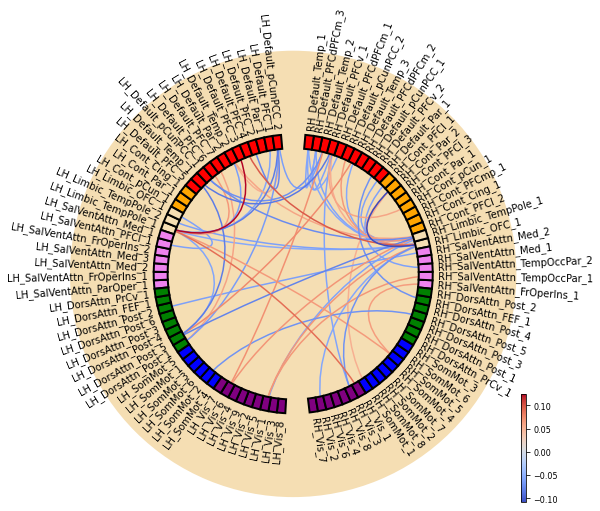

(<Figure size 720x720 with 2 Axes>, <PolarAxesSubplot:>)

In [92]:
##Link: https://mne.tools/stable/auto_examples/connectivity/plot_mne_inverse_label_connectivity.html

i_1 = []
i_2 = []
for f in range(len(df)):
    feature = df.iloc[f,:]
    i_1.append(node_names.index(feature['node1']))
    i_2.append(node_names.index(feature['node2']))
indices = (np.array(i_1), np.array(i_2))

lh_names = [name for name in node_names if 'LH' in name]
rh_names = [name for name in node_names if 'RH' in name]
lh_ordered = []
rh_ordered = []
net_names = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']
#net_names = net_list
for network in net_names: 
    lh_net_names = [name for name in lh_names if network in name]
    lh_ordered = lh_ordered + lh_net_names

    rh_net_names = [name for name in rh_names if network in name]
    rh_ordered = rh_ordered + rh_net_names
lh_ordered.reverse()
ordered = lh_ordered + rh_ordered

layout = circular_layout(node_names=node_names, node_order=ordered, group_boundaries=[0, len(lh_ordered)])
colors_list = ['purple', 'blue', 'green', 'violet', 'wheat', 'orange', 'red']
#colors_list = color_list
#colors_list = [(120/255, 18/255, 133/255), (70/255, 130/255, 180/255), (0/255, 118/255, 14/255), (196/255, 57/255, 248/255), (220/255, 248/255, 162/255), (230/255, 146/255, 32/255), (204/255, 60/255, 78/255)]

color_dict = dict(zip(net_names, colors_list))
node_colors = []
for name in node_names:
    net = name.split('_')[1]
    node_colors.append(color_dict[net])

#colormap_r = ListedColormap(colormap.colors[::-1])

fig = plt.figure(figsize=[10,10], facecolor='white')
plot_connectivity_circle(con, node_names, indices ,fontsize_names=10, n_lines = 50,
                         textcolor='black', facecolor='wheat', node_angles=layout, 
                        node_colors=node_colors, fig=fig, colormap='coolwarm', colorbar=True) 



## Plot several graphs together

In [47]:
import plot_con_helper
import importlib

importlib.reload(plot_con_helper)

#Paths to results 
PATH = conf.RESULTS_DIR

#Plot results of all 3 tasks
dfs = ['reg_z_compare_f', 'reg_F', 'reg_DD']

df_arranged = {}
for i in range(len(dfs)):
    path = PATH + '{}.csv'.format(dfs[i])
    df = pd.read_csv(path)
    df = df[['node1', 'node2', 'R']] #For reg analysis
    #df = df[['node1', 'node2', 'beta']] #For models
    df.columns = ['node1', 'node2', 'beta']
    df_arranged[dfs[i]] = df
    
#For every df, checks if all pair of nodes that exist in both tasks exist in the df. 
#if not, append it to the df with a beta of np.nan.
df_arranged = plot_con_helper.equalize_parc(df_arranged)
       

In [48]:
#Add columns to df: beta_abs, node1_networks, and node2_networks
importlib.reload(plot_con_helper)

for key in df_arranged.keys():
    plot_con_helper.add_col(df_arranged[key])

In [49]:
#Sort df according to beta_abs
for key in df_arranged.keys():
    df_arranged[key] =  df_arranged[key].sort_values(by=['beta_abs'], ascending=False,  ignore_index=True)
    df_arranged[key]['beta'] = df_arranged[key]['beta'].replace(np.nan, 0)

In [50]:
importlib.reload(plot_con_helper)

node_names_lis = []
con_lis = []
indices_lis = []
ordered_lis = []
node_colors_lis = []
layout_lis = []

for key in df_arranged.keys():
    node_names, con, indices, ordered, node_colors, layout = plot_con_helper.plot_con_helper(df_arranged[key])
    node_names_lis.append(node_names)
    con_lis.append(con)
    indices_lis.append(indices)
    ordered_lis.append(ordered)
    node_colors_lis.append(node_colors)
    layout_lis.append(layout)

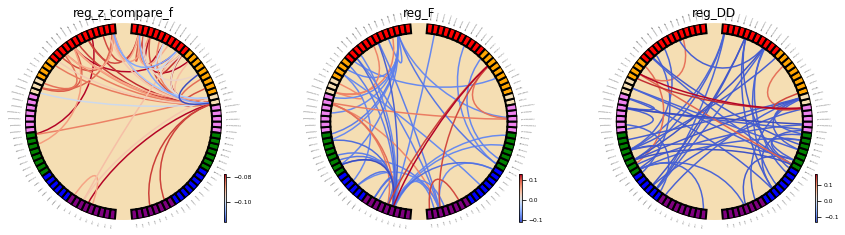

In [51]:
#Plot results of all 3 tasks
##Link: https://mne.tools/stable/auto_examples/connectivity/plot_mne_inverse_label_connectivity.html

fig = plt.figure(num=None, figsize=(15, 15), facecolor='white')
#no_names = [''] * len(label_names)
for ii, df in enumerate(dfs):
    plot_connectivity_circle(con_lis[ii], node_names_lis[ii], indices_lis[ii] ,fontsize_names=0, n_lines=50,
                              textcolor='black', facecolor='wheat', node_angles=layout_lis[ii], 
                             node_colors=node_colors_lis[ii],
                             title=df, padding=0, fontsize_colorbar=6, colormap='coolwarm',
                             fig=fig, subplot=(len(dfs), len(dfs), ii + 1), show = False)
     
plt.show()

# Find common edges between tasks

In [43]:
#Paths to results 
PATH = conf.RESULTS_DIR

#Create a dict of all the dfs

dfs = ['df_MC_02', 'df_F_02']

df_arranged = {}
for i in range(len(dfs)):
    path = PATH + '{}.csv'.format(dfs[i])
    df = pd.read_csv(path)
    df = df[['node1', 'node2', 'beta']]
    df_arranged[dfs[i]] = df

In [44]:
#Add columns to df: beta_abs, node1_networks, and node2_networks
importlib.reload(plot_con_helper)

for key in df_arranged.keys():
    plot_con_helper.add_col(df_arranged[key])

In [45]:
df_arranged[dfs[0]]

,node1,node2,beta,beta_abs,node1_nets,node2_nets
0,LH_Vis_2,LH_SalVentAttn_FrOperIns_2,0.004639,0.004639,Vis,SalVentAttn
1,LH_Vis_2,RH_Cont_PFCl_3,0.003485,0.003485,Vis,Cont
2,LH_Vis_3,LH_Vis_8,0.004081,0.004081,Vis,Vis
3,LH_Vis_3,LH_SalVentAttn_FrOperIns_2,0.003738,0.003738,Vis,SalVentAttn
4,LH_Vis_3,LH_Default_PFC_5,-0.001950,0.001950,Vis,Default
...,...,...,...,...,...,...
118,RH_Cont_PFCl_3,RH_Default_Temp_3,0.006180,0.006180,Cont,Default
119,RH_Default_Par_1,RH_Default_PFCv_1,0.003925,0.003925,Default,Default
120,RH_Default_Temp_1,RH_Default_PFCdPFCm_1,0.002546,0.002546,Default,Default
121,RH_Default_PFCv_1,RH_Default_PFCv_2,0.002564,0.002564,Default,Default


In [46]:
#Compare specific networks
res = plot_con_helper.compare_edges(df_arranged, key1 = dfs[0], key2 = dfs[1])

res

[['LH_Vis_5', 'LH_SalVentAttn_PFCl_1'],
 ['LH_Vis_5', 'RH_Cont_PFCl_3'],
 ['LH_Default_Temp_2', 'LH_Default_PFC_1'],
 ['LH_Default_PFC_5', 'RH_Cont_pCun_1'],
 ['RH_Vis_3', 'RH_Vis_7'],
 ['RH_Vis_5', 'RH_Cont_PFCl_3'],
 ['RH_Vis_8', 'RH_Default_PFCdPFCm_2'],
 ['RH_SalVentAttn_FrOperIns_1', 'RH_Cont_Par_1'],
 ['RH_Limbic_TempPole_1', 'RH_Default_PFCv_1'],
 ['RH_Cont_Par_1', 'RH_Cont_PFCl_2'],
 ['RH_Default_Par_1', 'RH_Default_PFCv_1'],
 ['RH_Default_PFCv_1', 'RH_Default_PFCv_2']]

In [6]:
#Compare common network edges (e.g. 7 networks)
importlib.reload(plot_con_helper)

df_common = plot_con_helper.find_common_netEdges(df_arranged)

df_common.head(60)

The assignments are in diffrent size
284
284


,Node1,Node2,network_pair,Beta(df_DD_02),Beta(df_F_02),df_name,count_pairNet_per_dfName,count_pairNet
0,LH_DorsAttn_Post_4,LH_Default_pCunPCC_2,DorsAttn-Default,-0,Empty,df_DD_02,35,46
1,LH_Default_Temp_2,RH_DorsAttn_Post_1,DorsAttn-Default,-0,Empty,df_DD_02,35,46
2,LH_Default_Temp_1,RH_DorsAttn_Post_3,DorsAttn-Default,0,Empty,df_DD_02,35,46
3,LH_Default_Temp_1,RH_DorsAttn_Post_2,DorsAttn-Default,0,Empty,df_DD_02,35,46
4,LH_Default_Temp_1,RH_DorsAttn_Post_1,DorsAttn-Default,-0,Empty,df_DD_02,35,46
5,LH_Default_PFC_3,RH_DorsAttn_Post_1,DorsAttn-Default,Empty,-0.0275172,df_F_02,11,46
6,LH_Default_PFC_3,RH_DorsAttn_Post_2,DorsAttn-Default,Empty,-0.0548412,df_F_02,11,46
7,LH_Default_PFC_3,RH_DorsAttn_PrCv_1,DorsAttn-Default,Empty,-0.166266,df_F_02,11,46
8,LH_DorsAttn_Post_2,LH_Default_PFC_3,DorsAttn-Default,Empty,-0.0358009,df_F_02,11,46
9,LH_DorsAttn_Post_6,RH_Default_pCunPCC_2,DorsAttn-Default,0,Empty,df_DD_02,35,46


In [8]:
g=df_common[(df_common["Beta(df_DD_02)"]!="Empty")&(df_common["Beta(df_F_02)"]!="Empty")]
g

,Node1,Node2,network_pair,Beta(df_DD_02),Beta(df_F_02),df_name,count_pairNet_per_dfName,count_pairNet
55,RH_Default_Par_1,RH_Default_PFCv_1,Default-Default,0.170101,0.127877,df_DD_02,12,26
62,RH_Default_Par_1,RH_Default_PFCv_1,Default-Default,0.170101,0.127877,df_F_02,14,26
201,LH_Vis_4,RH_Cont_PFCl_3,Vis-Cont,0,0.38192,df_DD_02,4,11
216,LH_Vis_4,RH_Cont_PFCl_3,Vis-Cont,0,0.38192,df_F_02,7,11
244,RH_Cont_Par_1,RH_Cont_PFCl_2,Cont-Cont,0.0477324,-0.0737825,df_DD_02,6,8
249,RH_Cont_Par_1,RH_Cont_PFCl_2,Cont-Cont,0.0477324,-0.0737825,df_F_02,2,8
270,LH_Vis_4,LH_SalVentAttn_PFCl_1,Vis-SalVentAttn,0.158933,0.166757,df_F_02,4,7
272,LH_Vis_4,LH_SalVentAttn_PFCl_1,Vis-SalVentAttn,0.158933,0.166757,df_DD_02,3,7


In [9]:
union = pd.concat([df_arranged[key1], df_arranged[key2]])

NameError: name 'key1' is not defined

In [501]:
union

,node1,node2,beta,beta_abs,node1_nets,node2_nets
0,LH_Vis_2,LH_Vis_4,-0.182916,0.182916,Vis,Vis
1,LH_Vis_2,LH_Vis_5,-0.398821,0.398821,Vis,Vis
2,LH_Vis_2,RH_SalVentAttn_Med_1,0.101689,0.101689,Vis,SalVentAttn
3,LH_Vis_4,LH_SalVentAttn_PFCl_1,0.096027,0.096027,Vis,SalVentAttn
4,LH_Vis_4,LH_Default_PFC_2,-0.146710,0.146710,Vis,Default
...,...,...,...,...,...,...
118,RH_Cont_PFCl_2,RH_Default_Temp_3,0.394507,0.394507,Cont,Default
119,RH_Default_Par_1,RH_Default_PFCdPFCm_1,0.182004,0.182004,Default,Default
120,RH_Default_Par_1,RH_Default_pCunPCC_2,0.228514,0.228514,Default,Default
121,RH_Default_Temp_1,RH_Default_PFCdPFCm_1,0.098874,0.098874,Default,Default
